In [3]:
import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
from calibration.calib_in_pcd import imgs_to_pcd, rs_ci
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb

resource_path = Path("../../resources")

class Args:
    model = resource_path / "models/calibrated/3d_aligned_not_cropped/M_1/bs17_augFalse_nanmaskTrue_sc0.5_23161120399152/e500.pth"
    input = resource_path / "images/calibrated/3d_aligned_not_cropped/dataset_4"
    scale = 0.5

args = Args()
dataset = DatasetInterface(Path(args.input))

net = UNet(n_input_channels=5, n_output_channels=1)
net = nn.DataParallel(net)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(args.model, map_location=device))
net.eval()

logging.info('Model loaded!')


INFO - 2022-02-07 08:57:38,320 - 3237755302 - Loading model ../../resources/models/calibrated/3d_aligned_not_cropped/M_1/bs17_augFalse_nanmaskTrue_sc0.5_23161120399152/e500.pth
INFO - 2022-02-07 08:57:38,320 - 3237755302 - Using device cpu
INFO - 2022-02-07 08:57:39,165 - 3237755302 - Model loaded!


INFO - 2022-02-07 08:57:42,991 - 546014651 - 
Predicting image ../../resources/images/calibrated/3d_aligned_not_cropped/dataset_4/1643104631.3747644.npz ...


Means: Input 0.3180822730064392 Label 0.22258855402469635 Predicted 0.21512159705162048
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


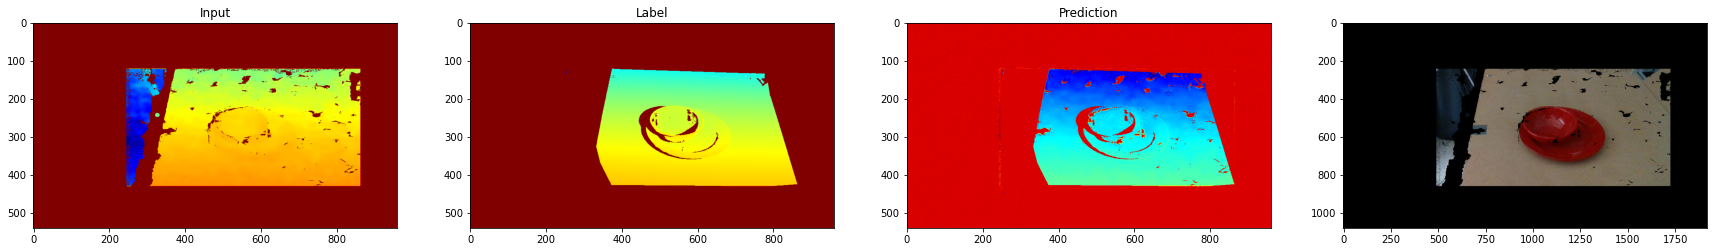

In [4]:

idx = np.random.randint(len(dataset), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth = dataset[idx]

logging.info(f'\nPredicting image {dataset.data_file_paths[idx]} ...')

# crop_region_mask = np.zeros((rs_rgb.shape[:2]), dtype=np.uint8)
# crop_region_mask[:, 500:1600] = 1
# rs_rgb = rs_rgb * crop_region_mask[..., None]
# zv_rgb = zv_rgb * crop_region_mask[..., None]
# rs_depth = np.where(crop_region_mask, rs_depth, np.nan)
# zv_depth = np.where(crop_region_mask, zv_depth, np.nan)

set = BasicDataset.preprocess_set(rs_rgb, rs_depth, zv_depth, scale=args.scale, add_mask_for_nans=True)
img = set['image']
nan_mask = set['nan-mask']
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    pred_depths = net(img)
    pred_depth = (pred_depths * nan_mask)[0, 0].float().cpu().detach().numpy()

input_rgb = BasicDataset.resize(rs_rgb, args.scale)
output_rgb = BasicDataset.resize(zv_rgb, args.scale)
input_depth = BasicDataset.resize(rs_depth, args.scale)
real_depth = BasicDataset.resize(zv_depth, args.scale)
depths = np.concatenate((input_depth, pred_depth, real_depth), axis=1)

real_depth = np.nan_to_num(real_depth)
input_depth = np.nan_to_num(input_depth)

print(f"Means: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.mean(pred_depth)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth, rs_ci)
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)
o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))